In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")
options(repr.plot.width=10, repr.plot.height=8)

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv")

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)

drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))

proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence"))

wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



ERROR: Error in eval(expr, envir, enclos): object 'Gene' not found



Attaching package: ‘scales’

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric

Loading required package: RColorBrewer


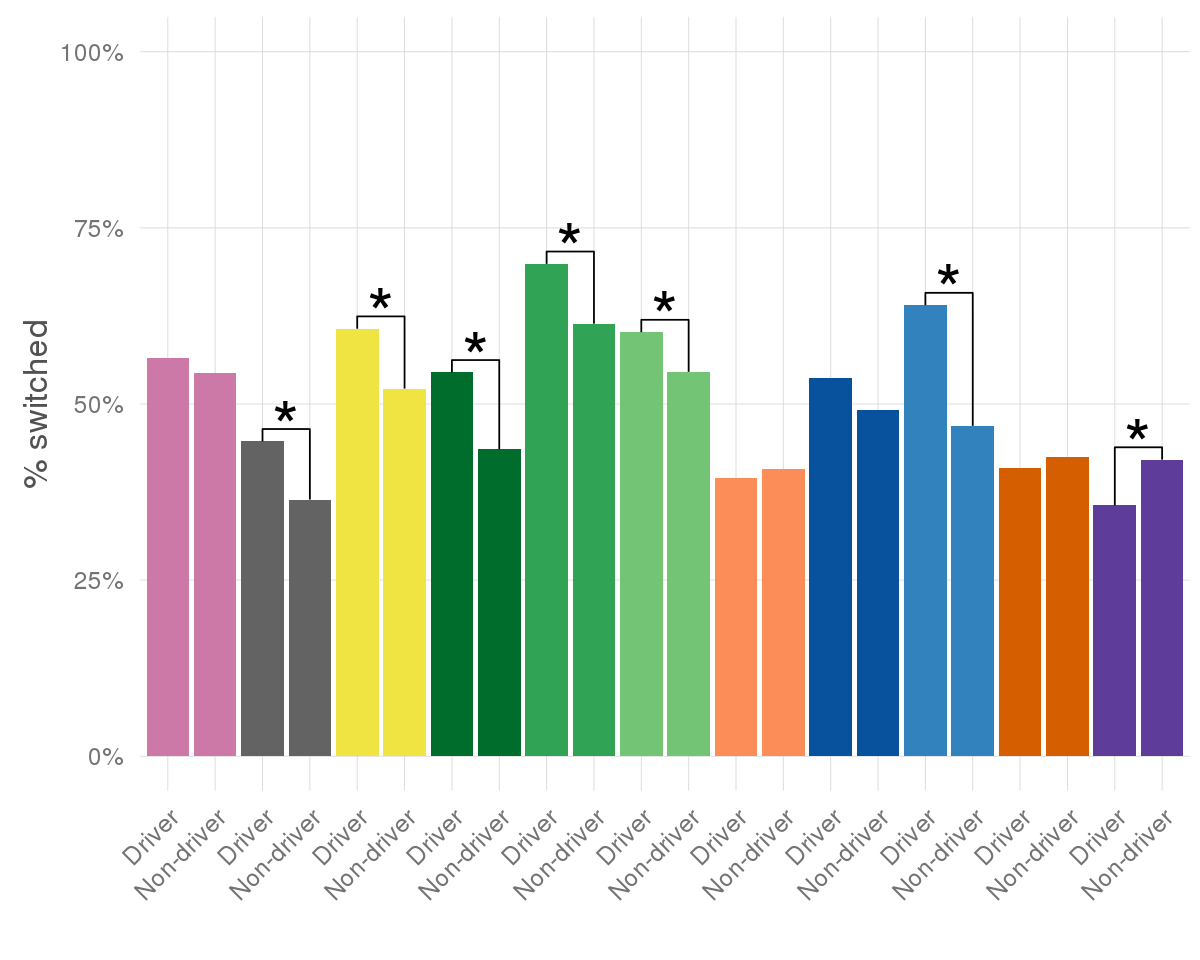

In [2]:
library(scales)
library(ggstars)

proteome.drivers <- proteome %>%
    filter(asEvidence=="True") %>%
    mutate(Driver = as.numeric(Symbol %in% drivers$Symbol) ) %>%
    select(Tumor,GeneId, Driver)
    
proteome.switches <- proteome %>%
    filter(asEvidence=="True") %>%
    merge(switches.split %>% filter(IsFunctional==1)) %>%
    select(Tumor,GeneId) %>%
    mutate(Switch=1)

driver.enrichment <- proteome %>%
    filter(asEvidence=="True") %>%
    merge(proteome.drivers, all.x=T) %>%
    merge(proteome.switches, all.x=T) %>%
    mutate(Driver = ifelse(is.na(Driver), 0, Driver),
           Switch = ifelse(is.na(Switch), 0, Switch)) %>%
    group_by(Tumor) %>%
    summarise(SwDr = sum(Driver==1 & Switch==1),
              NSwDr = sum(Driver==1 & Switch==0),
              SwNDr = sum(Driver==0 & Switch==1),
              NSwNDr = sum(Driver==0 & Switch==0))

driver.enrichment <- apply(driver.enrichment[,2:5],1,function(x){
    f <- fisher.test(matrix(x,2,2))
    p <- f$p.value
    OR <- as.numeric(f$estimate)
    c(p=p,OR=OR)
}) %>% t%>% as.data.frame %>%
    cbind(driver.enrichment,.)

driver.enrichment.melt <- driver.enrichment %>%
    select(-p, -OR) %>%
    melt(id.vars="Tumor") %>%
    mutate( Driver = ifelse(variable %in% c("SwDr","NSwDr"), "Driver", "Non-driver"),
            Switch = ifelse(variable %in% c("SwDr","SwNDr"), "Switch", "No switch"),
            Tag = paste(Tumor, Driver, sep="_"))

axisLabels <- strsplit(driver.enrichment.melt$Tag, "_") %>% unlist %>% .[c(F,T)]
names(axisLabels) <- driver.enrichment.melt$Tag

p <- ggplot(driver.enrichment.melt , aes(x=Tag, y=value, fill=Tumor, alpha=Switch)) +
    geom_bar(stat="identity",position="fill") +
    labs(x="", y="% switched") +
    clean_theme() +
    scale_fill_manual(values=colorPalette) +
    scale_alpha_manual(values=c("Switch"=1, "No switch"=0)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=axisLabels) +
    scale_y_continuous(labels = percent)

star_bar(p, driver.enrichment$p < 0.05)